# Oceanstream - EK80 Example

### Setting up project root for module imports in Jupyter Notebook

In [1]:
# Import the os module to work with the file system
import os

# Get the absolute path of the current notebook.
# This assumes the notebook's name is "oceanstream_ek80_example_T133707.ipynb".
# Note: "oceanstream_ek80_example_T133707.ipynb" is located in the "notebooks" folder of the "oceanstream" repo.
# This folder is typically ignored to maintain a clear organization of the project.
notebook_path = os.path.abspath("oceanstream_ek80_example_T133707.ipynb")
notebooks_folder_path = os.path.abspath(os.path.join(notebook_path, os.pardir))

# Navigate up two directories from the notebook's path to get to the project root
project_root = os.path.abspath(os.path.join(notebook_path, os.pardir, os.pardir))

# Import the sys module to modify the Python path
import sys

# Append the project root to the Python path so that modules from the project can be imported
sys.path.append(project_root)

**Specifies the path to the test data utilized in this notebook:**

In [2]:
oceanstream_ek80_path =  os.path.join(notebooks_folder_path, "test_data", "oceanstream_ek80_T133707")

### Imports

In [3]:
import gc
import os
import urllib.request

import echopype.visualize as epviz
import fsspec
import matplotlib.pyplot as plt

from oceanstream.L0_unprocessed_data import raw_reader, ensure_time_continuity
from oceanstream.L2_calibrated_data import (
    sv_computation,
    sv_dataset_extension,
    noise_masks,
    sv_interpolation,
    processed_data_io
)
from oceanstream.L3_regridded_data import (
    applying_masks_handler,
    nasc_computation,
    frequency_differencing_handler,
    shoal_detection_handler
)
from oceanstream.L3_regridded_data.applying_masks_handler import apply_mask_organisms_in_order
from oceanstream.L3_regridded_data.mvbs_computation import compute_mvbs
from oceanstream.utils import add_metadata_to_mask, attach_mask_to_dataset, dict_to_formatted_list

In [4]:
# Load the memory_profiler extension to enable memory usage profiling in the notebook
%load_ext memory_profiler

### Downloads the test files

In [5]:
# Initialize the S3 filesystem using anonymous access
fs = fsspec.filesystem('s3', anon=True)

bucket = "noaa-wcsd-pds"
rawdirpath = "data/raw/Pisces/PC1905/EK80"

# List files in the S3 directory
s3_files = fs.glob(f"{bucket}/{rawdirpath}/*")

# Filter the files based on your criteria (e.g., containing a specific string)
target_files = [s3path for s3path in s3_files if any([f"D2019{dtstr}" in s3path for dtstr in ['0925-T133707']])]

print(f"There are {len(target_files)} target files available")


There are 1 target files available


In [6]:
local_folder = oceanstream_ek80_path

# Create the local folder if it doesn't exist
os.makedirs(local_folder, exist_ok=True)

# Download the filtered files to the local folder
for s3path in target_files:
    file_name = os.path.basename(s3path)
    local_file_path = os.path.join(local_folder, file_name)
    with fs.open(s3path, 'rb') as s3_file, open(local_file_path, 'wb') as local_file:
        local_file.write(s3_file.read())

print(f"Downloaded {len(target_files)} target raw files to {local_folder}")

Downloaded 1 target raw files to /Users/simedroniraluca/Documents/pineview/oceanstream/notebooks/test_data/oceanstream_ek80_T133707


### Files manipulation

**File finder**

In [7]:
%%time

# Displays all `.raw` files from the "oceanstream_ek80_T133707" directory
%memit raw_files_path = raw_reader.file_finder(oceanstream_ek80_path, file_type='raw')
display(raw_files_path)

peak memory: 271.05 MiB, increment: 0.04 MiB


['/Users/simedroniraluca/Documents/pineview/oceanstream/notebooks/test_data/oceanstream_ek80_T133707/D20190925-T133707.raw']

CPU times: user 84.1 ms, sys: 12.5 ms, total: 96.7 ms
Wall time: 647 ms


**File integrity checker**

In [8]:
%%time

# Verifies if the provided echo sounder files are
# readable by echopype and extracts
# essential metadata such as the campaign ID, date of measurement,
# and sonar model.
raw_files_ck = []
for file_path in raw_files_path:
    %memit raw_files_ck.append(raw_reader.file_integrity_checking(file_path))
    
raw_files_ck

peak memory: 1401.18 MiB, increment: 1130.11 MiB
CPU times: user 11 s, sys: 830 ms, total: 11.8 s
Wall time: 12.4 s


[{'file_path': '/Users/simedroniraluca/Documents/pineview/oceanstream/notebooks/test_data/oceanstream_ek80_T133707/D20190925-T133707.raw',
  'campaign_id': 'D20190925',
  'date': datetime.datetime(2019, 9, 25, 13, 37, 7),
  'sonar_model': 'EK80',
  'file_integrity': True}]

**Checked raw files reader**

In [9]:
%%time

# Reads multiple raw echo sounder files and returns a list of Datasets.
%memit aug2019_ds = raw_reader.read_raw_files(raw_files_ck)
aug2019_ds[0]

peak memory: 1396.51 MiB, increment: 951.33 MiB
CPU times: user 5.03 s, sys: 646 ms, total: 5.67 s
Wall time: 6.4 s


<EchoData: standardized raw data from Internal Memory>
Top-level: contains metadata about the SONAR-netCDF4 file format.
├── Environment: contains information relevant to acoustic propagation through water.
├── Platform: contains information about the platform on which the sonar is installed.
│   └── NMEA: contains information specific to the NMEA protocol.
├── Provenance: contains metadata about how the SONAR-netCDF4 version of the data were obtained.
├── Sonar: contains sonar system metadata and sonar beam groups.
│   └── Beam_group1: contains backscatter power (uncalibrated) and other beam or channel-specific data, including split-beam angle data when they exist.
└── Vendor_specific: contains vendor-specific information about the sonar and the data.

### Clearing Memory

-  Releasing the memory occupied by the `echodata` object ensures that resources are freed up, especially important in environments like Jupyter notebooks where variables persist in memory until the kernel is restarted.

In [10]:
del aug2019_ds
gc.collect()  # Run the garbage collector to free up memory immediately

44

### NetCDF files obtained from raw files

**Raw file converter to 'nc' or 'zarr'**

In [11]:
%%time

%memit raw_reader.convert_raw_files(raw_files_ck, oceanstream_ek80_path, save_file_type='nc')

peak memory: 1706.62 MiB, increment: 1175.17 MiB
CPU times: user 9.34 s, sys: 913 ms, total: 10.2 s
Wall time: 11.4 s


In [12]:
%%time

%memit raw_reader.convert_raw_files(raw_files_ck, oceanstream_ek80_path, save_file_type='zarr')

peak memory: 1747.06 MiB, increment: 968.19 MiB
CPU times: user 6.78 s, sys: 830 ms, total: 7.61 s
Wall time: 6.58 s


**File finder**

In [13]:
%%time

# Displays all `.nc` files from the "oceanstream_ek80_T133707" directory
%memit nc_files_path = raw_reader.file_finder(oceanstream_ek80_path, file_type='nc')
nc_files_path

peak memory: 803.61 MiB, increment: 0.00 MiB
CPU times: user 119 ms, sys: 42.2 ms, total: 162 ms
Wall time: 850 ms


['/Users/simedroniraluca/Documents/pineview/oceanstream/notebooks/test_data/oceanstream_ek80_T133707/D20190925-T133707.nc']

**File integrity checker**

In [14]:
%%time

nc_files_ck = []
for file_path in nc_files_path:
    %memit nc_files_ck.append(raw_reader.file_integrity_checking(file_path))
    
nc_files_ck

peak memory: 818.20 MiB, increment: 14.59 MiB
CPU times: user 394 ms, sys: 67.3 ms, total: 462 ms
Wall time: 1.02 s


[{'file_path': '/Users/simedroniraluca/Documents/pineview/oceanstream/notebooks/test_data/oceanstream_ek80_T133707/D20190925-T133707.nc',
  'campaign_id': 'D20190925',
  'date': datetime.datetime(2019, 9, 25, 13, 37, 7),
  'sonar_model': 'EK80',
  'file_integrity': True}]

**Processed files reader**

In [15]:
%%time

%memit ds = raw_reader.read_processed_files(nc_files_path)

peak memory: 642.11 MiB, increment: 11.43 MiB
CPU times: user 422 ms, sys: 81.8 ms, total: 504 ms
Wall time: 1.23 s


In [16]:
ds = ds[0]

### Sv (Volume backscattering strength) computation

In [17]:
%%time

%memit sv = sv_computation.compute_sv(ds, waveform_mode="CW", encode_mode="power")
sv

peak memory: 1491.05 MiB, increment: 848.95 MiB
CPU times: user 1.23 s, sys: 387 ms, total: 1.61 s
Wall time: 2.19 s


<xarray.Dataset>
Dimensions:                        (channel: 4, ping_time: 4234,
                                    range_sample: 910, filenames: 1)
Coordinates:
  * channel                        (channel) <U27 'GPT 0090720346b4-1 ES38B' ...
  * ping_time                      (ping_time) datetime64[ns] 2019-09-25T13:3...
  * range_sample                   (range_sample) int64 0 1 2 3 ... 907 908 909
  * filenames                      (filenames) int64 0
Data variables: (12/24)
    Sv                             (channel, ping_time, range_sample) float64 ...
    echo_range                     (channel, ping_time, range_sample) float64 ...
    frequency_nominal              (channel) float64 ...
    sound_speed                    float64 1.51e+03
    sound_absorption               (channel) float64 0.009878 ... 0.05316
    temperature                    float64 10.0
    ...                             ...
    beamwidth_athwartship          (channel) float64 ...
    impedance_transducer           (channel) int64 75 75 75 75
    impedance_transceiver          (channel) int64 ...
    receiver_sampling_frequency    (channel) float64 ...
    source_filenames               (filenames) <U119 '/Users/simedroniraluca/...
    water_level                    float64 ...
Attributes:
    processing_software_name:     echopype
    processing_software_version:  0.1.dev2333+gc260127
    processing_time:              2023-11-10T07:28:47Z
    processing_function:          calibrate.compute_Sv

**Sv - with noise**

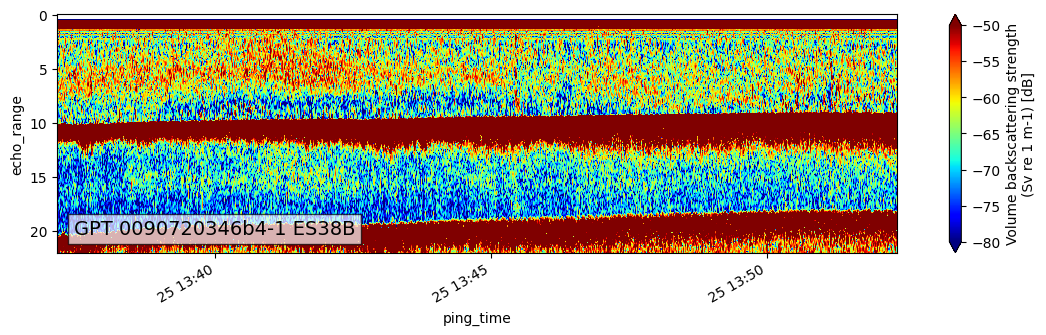

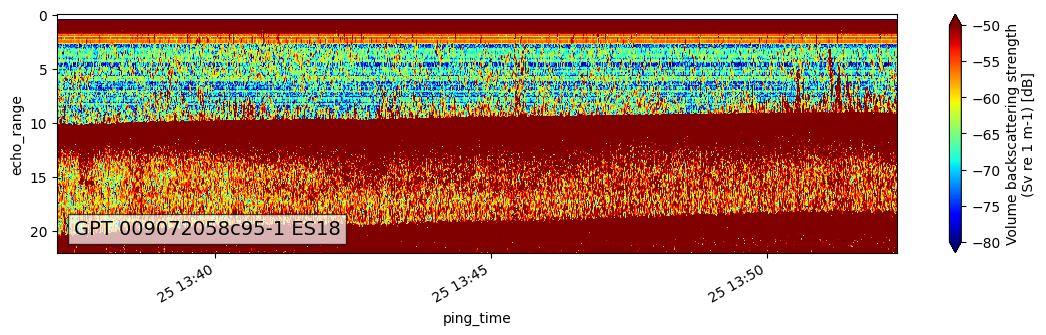

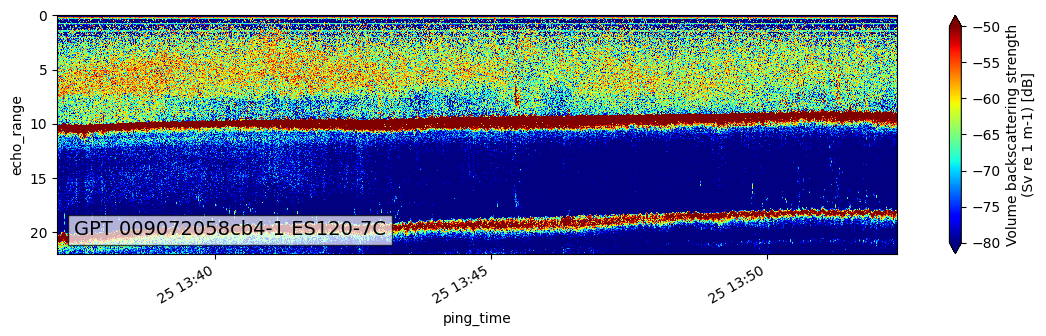

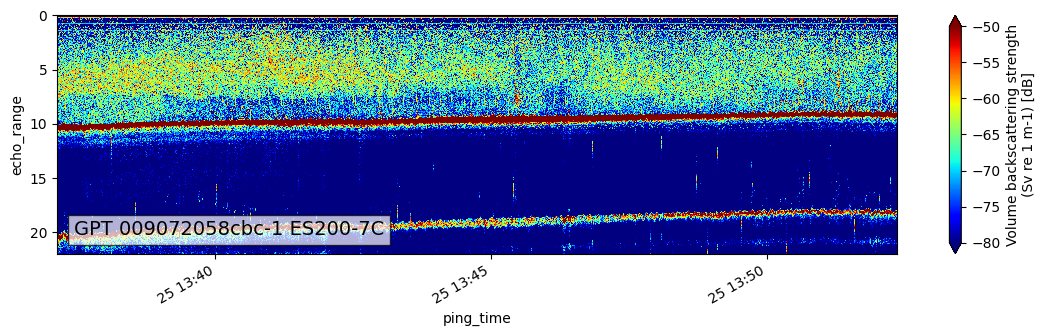

In [18]:
epviz.create_echogram(sv,vmin=-80,vmax=-50)

### Sv dataset extension

In [19]:
%%time

extended_sv = sv_dataset_extension.enrich_sv_dataset(
    sv = sv,
    echodata = ds, 
    waveform_mode="CW",
    encode_mode="power"
)
extended_sv

CPU times: user 703 ms, sys: 251 ms, total: 954 ms
Wall time: 1.07 s


<xarray.Dataset>
Dimensions:                        (channel: 4, ping_time: 4234,
                                    range_sample: 910, filenames: 1)
Coordinates:
  * channel                        (channel) <U27 'GPT 0090720346b4-1 ES38B' ...
  * ping_time                      (ping_time) datetime64[ns] 2019-09-25T13:3...
  * range_sample                   (range_sample) int64 0 1 2 3 ... 907 908 909
  * filenames                      (filenames) int64 0
Data variables: (12/29)
    Sv                             (channel, ping_time, range_sample) float64 ...
    echo_range                     (channel, ping_time, range_sample) float64 ...
    frequency_nominal              (channel) float64 ...
    sound_speed                    float64 1.51e+03
    sound_absorption               (channel) float64 0.009878 ... 0.05316
    temperature                    float64 10.0
    ...                             ...
    water_level                    float64 ...
    depth                          (channel, ping_time, range_sample) float64 ...
    latitude                       (ping_time) float64 nan nan 30.15 ... nan nan
    longitude                      (ping_time) float64 nan nan ... nan nan
    angle_alongship                (channel, ping_time, range_sample) float64 ...
    angle_athwartship              (channel, ping_time, range_sample) float64 ...
Attributes:
    processing_software_name:     echopype
    processing_software_version:  0.1.dev2333+gc260127
    processing_time:              2023-11-10T07:28:47Z
    processing_function:          calibrate.compute_Sv
    processing_level:             Level 2A
    processing_level_url:         https://echopype.readthedocs.io/en/stable/p...

In [20]:
%memit extended_sv = sv_dataset_extension.enrich_sv_dataset(sv=sv, echodata=ds, waveform_mode="CW", encode_mode="power")

peak memory: 2632.78 MiB, increment: 365.05 MiB


### Clearing Memory

In [21]:
del ds
del sv
gc.collect()  # Run the garbage collector to free up memory immediately

780

### Noise masks

- **Compute noise masks and add them as variables to the dataset (using `create_noise_masks_oceanstream` function)**
- Notes:
    - The `create_noise_masks_oceanstream` function is designed to generate noise masks and add them to a specific Sv dataset, utilizing default methods set by the oceanstream team for the foundational operations of oceanstream. This feature can be adjusted based on evaluations with various datasets. Within the mask attributes, the function provides insights into the methods employed for each distinct mask type.

In [22]:
# %%time

# %memit oceanstream_ek80_extended_ds = noise_masks.create_noise_masks_oceanstream(extended_sv)
# oceanstream_ek80_extended_ds

**Important Remarks** 
- Compute noise masks and add them as variables to the dataset (using create_noise_masks_oceanstream function) is not possible because of the transient mask computation, which kills the kernel for large datasets.
- The attenuation mask has a bug.
- The temporary solution is to compute impulse noise mask. 

**`Impulse` noise mask**

In [23]:
%%time

oceanstream_impulse_mask_param = {"thr": 3, "m": 3, "n": 1}
%memit impulse_mask = noise_masks.create_impulse_mask(extended_sv, parameters=oceanstream_impulse_mask_param, method="ryan")
impulse_mask = add_metadata_to_mask(
    mask=impulse_mask,
    metadata={
        "mask_type": "impulse",
        "method": "ryan",
        "parameters": dict_to_formatted_list(oceanstream_impulse_mask_param),
    },
)

Sv_without_impulse = attach_mask_to_dataset(extended_sv, impulse_mask)
Sv_without_impulse 

peak memory: 2622.56 MiB, increment: 7.36 MiB
CPU times: user 1.27 s, sys: 361 ms, total: 1.63 s
Wall time: 2.28 s


<xarray.Dataset>
Dimensions:                        (channel: 4, ping_time: 4234,
                                    range_sample: 910, filenames: 1)
Coordinates:
  * channel                        (channel) object 'GPT 0090720346b4-1 ES38B...
  * ping_time                      (ping_time) datetime64[ns] 2019-09-25T13:3...
  * range_sample                   (range_sample) int64 0 1 2 3 ... 907 908 909
  * filenames                      (filenames) int64 0
Data variables: (12/30)
    Sv                             (channel, ping_time, range_sample) float64 ...
    echo_range                     (channel, ping_time, range_sample) float64 ...
    frequency_nominal              (channel) float64 ...
    sound_speed                    float64 1.51e+03
    sound_absorption               (channel) float64 0.009878 ... 0.05316
    temperature                    float64 10.0
    ...                             ...
    depth                          (channel, ping_time, range_sample) float64 ...
    latitude                       (ping_time) float64 nan nan 30.15 ... nan nan
    longitude                      (ping_time) float64 nan nan ... nan nan
    angle_alongship                (channel, ping_time, range_sample) float64 ...
    angle_athwartship              (channel, ping_time, range_sample) float64 ...
    mask_impulse                   (channel, ping_time, range_sample) bool Fa...
Attributes:
    processing_software_name:     echopype
    processing_software_version:  0.1.dev2333+gc260127
    processing_time:              2023-11-10T07:28:47Z
    processing_function:          calibrate.compute_Sv
    processing_level:             Level 2A
    processing_level_url:         https://echopype.readthedocs.io/en/stable/p...

In [24]:
oceanstream_ek80_extended_ds = Sv_without_impulse 

- **Compute `seabed` and `false seabed` masks and add them as variables to the dataset**
- Notes:
   - To effectively utilize the `blackwell_mod` method for seabed detection, ensure that the `Sv` dataset includes the `split-beam angle` parameters. Specifically, the input `Sv` dataset should contain both the `angle_alongship` and `angle_athwartship` variables. The absence of these variables will lead to errors.

In [25]:
%%time

# `blackwell_mod`

BLACKWELL_MOD_DEFAULT_PARAMS = {
    "theta": None,
    "phi": None,
    "r0": 10,
    "r1": 1000,
    "tSv": -75,
    "ttheta": 702,
    "tphi": 282,
    "wtheta": 28,
    "wphi": 52,
    "rlog": None,
    "tpi": None,
    "freq": None,
    "rank": 50,
}
blackwell_mod_mask = noise_masks.create_seabed_mask(
    oceanstream_ek80_extended_ds,
    method="blackwell_mod",
    parameters = BLACKWELL_MOD_DEFAULT_PARAMS,
    )
blackwell_mod_mask = add_metadata_to_mask(
    mask=blackwell_mod_mask , 
    metadata={
        "mask_type": "false_seabed", 
        "method":"blackwell_mod",
        "parameters": dict_to_formatted_list(BLACKWELL_MOD_DEFAULT_PARAMS),
    }
)

oceanstream_ek80_extended_ds = attach_mask_to_dataset(
    oceanstream_ek80_extended_ds, 
    blackwell_mod_mask
)


# `ariza`

# ARIZA_PARAMS = {
#     "r0": 10,
#     "r1": 1000,
#     "roff": 0,
#     "thr": -35,
#     "ec": 15,
#     "ek": (1, 3),
#     "dc": 150,
#     "dk": (1, 3),
# }
ARIZA_PARAMS = {
    "r0": 10,
    "r1": 1000,
    "roff": 0,
    "thr": -40,
    "ec": 1,
    "ek": (1, 3),
    "dc": 10,
    "dk": (3, 7),
}
ariza_mask = noise_masks.create_seabed_mask(
    oceanstream_ek80_extended_ds,
    method="ariza",
    parameters=ARIZA_PARAMS,
)
ariza_mask = add_metadata_to_mask(
    mask=ariza_mask,
    metadata={
        "mask_type": "seabed",
        "method": "ariza",
        "parameters": dict_to_formatted_list(ARIZA_PARAMS),
    },
)

oceanstream_ek80_extended_ds = attach_mask_to_dataset(
    oceanstream_ek80_extended_ds, 
    ariza_mask
)

oceanstream_ek80_extended_ds

/Users/simedroniraluca/Documents/pineview/oceanstream/.venv/lib/python3.9/site-packages/echopype/mask/seabed.py:496: UserWarning: Aliased seabed not detected in Theta & Phi.A default mask with all True values is returned.
  warnings.warn(


CPU times: user 16.7 s, sys: 175 ms, total: 16.9 s
Wall time: 17 s


<xarray.Dataset>
Dimensions:                        (channel: 4, ping_time: 4234,
                                    range_sample: 910, filenames: 1)
Coordinates:
  * channel                        (channel) object 'GPT 0090720346b4-1 ES38B...
  * ping_time                      (ping_time) datetime64[ns] 2019-09-25T13:3...
  * range_sample                   (range_sample) int64 0 1 2 3 ... 907 908 909
  * filenames                      (filenames) int64 0
Data variables: (12/32)
    Sv                             (channel, ping_time, range_sample) float64 ...
    echo_range                     (channel, ping_time, range_sample) float64 ...
    frequency_nominal              (channel) float64 ...
    sound_speed                    float64 1.51e+03
    sound_absorption               (channel) float64 0.009878 ... 0.05316
    temperature                    float64 10.0
    ...                             ...
    longitude                      (ping_time) float64 nan nan ... nan nan
    angle_alongship                (channel, ping_time, range_sample) float64 ...
    angle_athwartship              (channel, ping_time, range_sample) float64 ...
    mask_impulse                   (channel, ping_time, range_sample) bool Fa...
    mask_false_seabed              (channel, ping_time, range_sample) bool Tr...
    mask_seabed                    (channel, ping_time, range_sample) bool Tr...
Attributes:
    processing_software_name:     echopype
    processing_software_version:  0.1.dev2333+gc260127
    processing_time:              2023-11-10T07:28:47Z
    processing_function:          calibrate.compute_Sv
    processing_level:             Level 2A
    processing_level_url:         https://echopype.readthedocs.io/en/stable/p...

### Applying masks

**We will apply only the impulse noise mask until the bug in the attenuation computation and the problems caused by the transient noise are resolved.**

(**Applies the following masks to the dataset in the specified order:**

1. `Apply impulse noise mask`

2. `Apply attenuation mask `

3. `Apply transient mask`)

CPU times: user 3.78 s, sys: 868 ms, total: 4.65 s
Wall time: 3.72 s


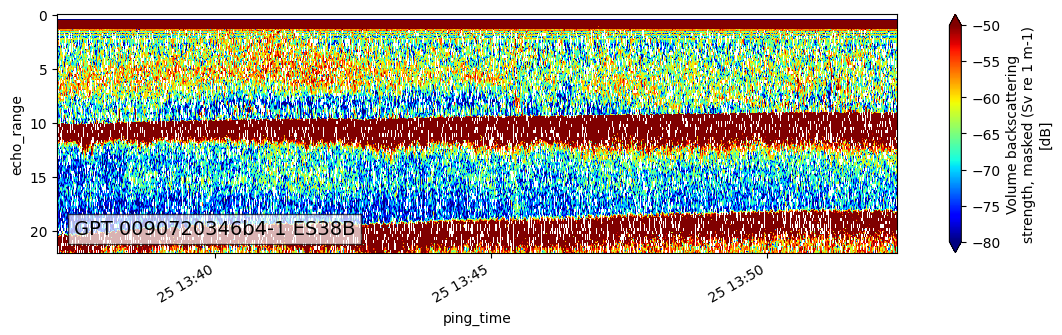

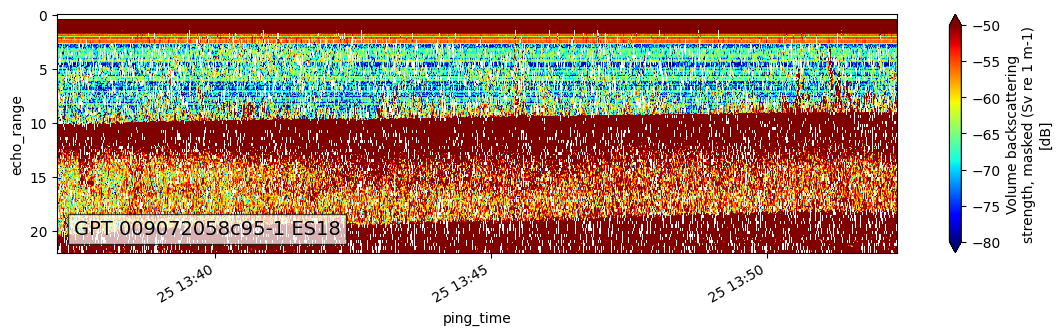

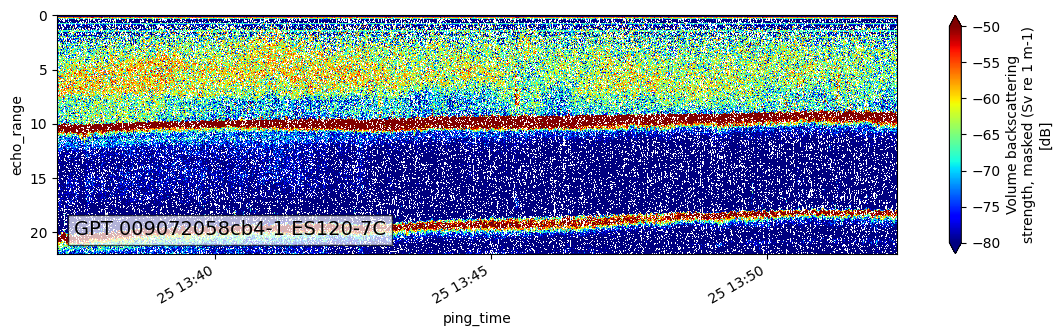

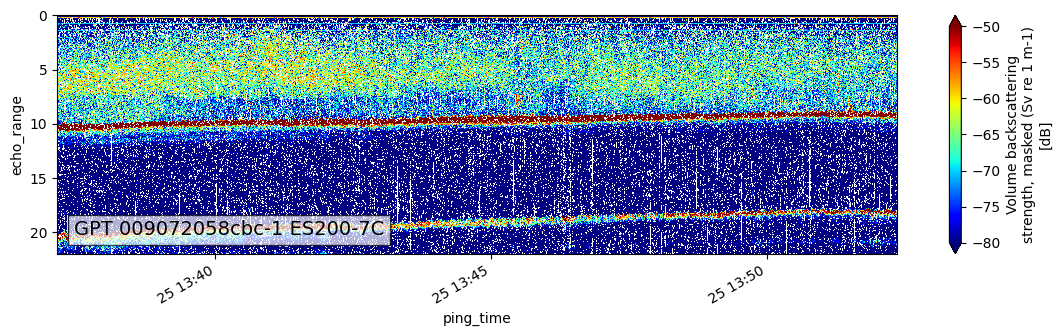

In [26]:
%%time

process_parameters = {
#     "mask_transient": {
#         "var_name": "Sv",
#     },
    "mask_impulse": {
        "var_name": "Sv",
    },
#     "mask_attenuation": {
#         "var_name": "Sv",
#     },
}
cleaned_ds = applying_masks_handler.apply_selected_noise_masks_and_or_noise_removal(
    oceanstream_ek80_extended_ds, 
    process_parameters
)
epviz.create_echogram(cleaned_ds,vmin=-80,vmax=-50)

### Sv interpolation

In [27]:
%%time

interpolated_ds = sv_interpolation.interpolate_sv(cleaned_ds)
interpolated_ds

CPU times: user 195 ms, sys: 21.2 ms, total: 216 ms
Wall time: 218 ms


<xarray.Dataset>
Dimensions:                        (channel: 4, ping_time: 4234,
                                    range_sample: 910, filenames: 1)
Coordinates:
  * channel                        (channel) <U27 'GPT 0090720346b4-1 ES38B' ...
  * ping_time                      (ping_time) datetime64[ns] 2019-09-25T13:3...
  * range_sample                   (range_sample) int64 0 1 2 3 ... 907 908 909
  * filenames                      (filenames) int64 0
Data variables: (12/33)
    Sv                             (channel, ping_time, range_sample) float64 ...
    echo_range                     (channel, ping_time, range_sample) float64 ...
    frequency_nominal              (channel) float64 ...
    sound_speed                    float64 1.51e+03
    sound_absorption               (channel) float64 0.009878 ... 0.05316
    temperature                    float64 10.0
    ...                             ...
    angle_alongship                (channel, ping_time, range_sample) float64 ...
    angle_athwartship              (channel, ping_time, range_sample) float64 ...
    mask_impulse                   (channel, ping_time, range_sample) bool Fa...
    mask_false_seabed              (channel, ping_time, range_sample) bool Tr...
    mask_seabed                    (channel, ping_time, range_sample) bool Tr...
    Sv_interpolated                (channel, ping_time, range_sample) float64 dask.array<chunksize=(1, 4234, 910), meta=np.ndarray>
Attributes:
    processing_software_name:     echopype
    processing_software_version:  0.1.dev2333+gc260127
    processing_time:              2023-11-10T07:28:47Z
    processing_function:          calibrate.compute_Sv
    processing_level:             Level 3A
    processing_level_url:         https://echopype.readthedocs.io/en/stable/p...
    mask_software_name:           echopype
    mask_software_version:        0.1.dev2333+gc260127
    mask_time:                    2023-11-10T07:29:22Z
    mask_function:                mask.apply_mask

In [28]:
# Rename Sv to Sv_denoised
# Rename Sv_interpolated to Sv
interpolated_ds = interpolated_ds.rename({"Sv": "Sv_denoised", "Sv_interpolated": "Sv"})

interpolated_ds

<xarray.Dataset>
Dimensions:                        (channel: 4, ping_time: 4234,
                                    range_sample: 910, filenames: 1)
Coordinates:
  * channel                        (channel) <U27 'GPT 0090720346b4-1 ES38B' ...
  * ping_time                      (ping_time) datetime64[ns] 2019-09-25T13:3...
  * range_sample                   (range_sample) int64 0 1 2 3 ... 907 908 909
  * filenames                      (filenames) int64 0
Data variables: (12/33)
    Sv_denoised                    (channel, ping_time, range_sample) float64 ...
    echo_range                     (channel, ping_time, range_sample) float64 ...
    frequency_nominal              (channel) float64 ...
    sound_speed                    float64 1.51e+03
    sound_absorption               (channel) float64 0.009878 ... 0.05316
    temperature                    float64 10.0
    ...                             ...
    angle_alongship                (channel, ping_time, range_sample) float64 ...
    angle_athwartship              (channel, ping_time, range_sample) float64 ...
    mask_impulse                   (channel, ping_time, range_sample) bool Fa...
    mask_false_seabed              (channel, ping_time, range_sample) bool Tr...
    mask_seabed                    (channel, ping_time, range_sample) bool Tr...
    Sv                             (channel, ping_time, range_sample) float64 dask.array<chunksize=(1, 4234, 910), meta=np.ndarray>
Attributes:
    processing_software_name:     echopype
    processing_software_version:  0.1.dev2333+gc260127
    processing_time:              2023-11-10T07:28:47Z
    processing_function:          calibrate.compute_Sv
    processing_level:             Level 3A
    processing_level_url:         https://echopype.readthedocs.io/en/stable/p...
    mask_software_name:           echopype
    mask_software_version:        0.1.dev2333+gc260127
    mask_time:                    2023-11-10T07:29:22Z
    mask_function:                mask.apply_mask

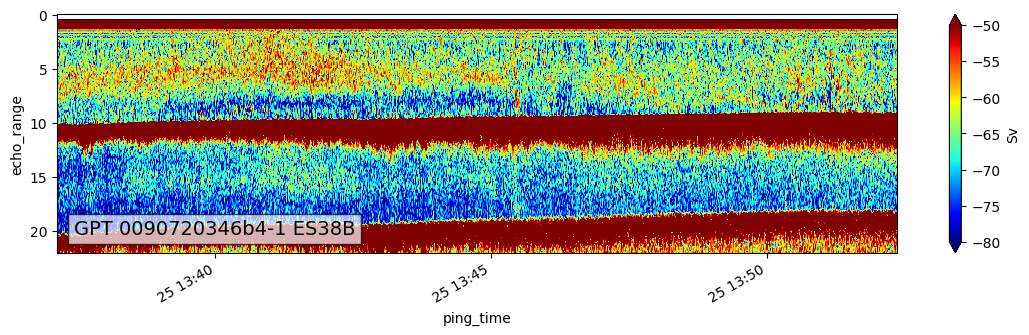

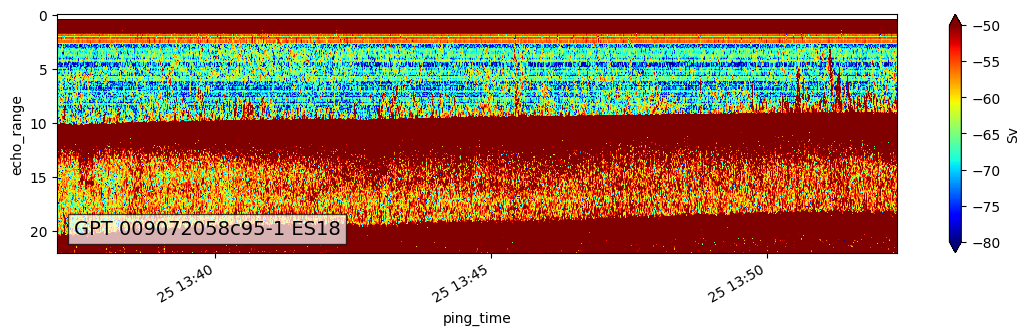

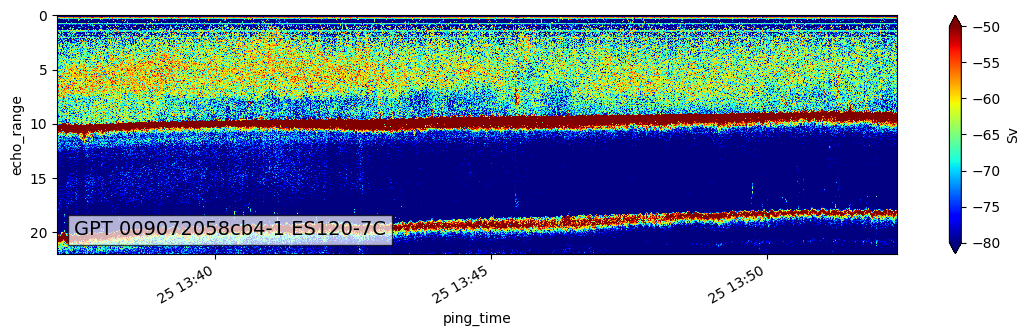

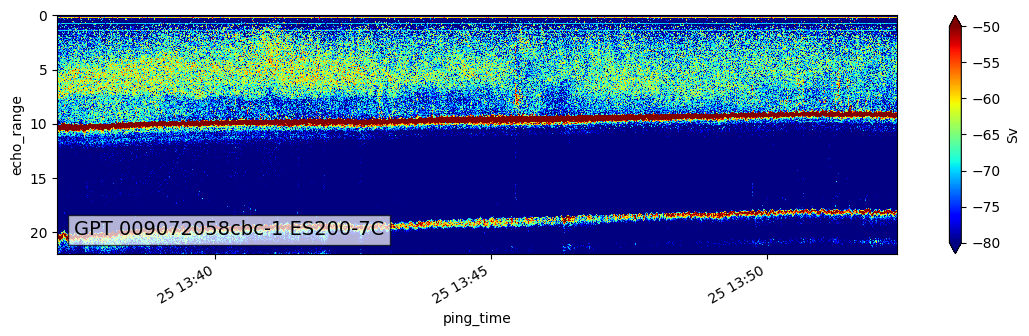

In [29]:
epviz.create_echogram(interpolated_ds,vmin=-80,vmax=-50)

### Remove background noise

CPU times: user 22.5 s, sys: 6.26 s, total: 28.8 s
Wall time: 16.7 s


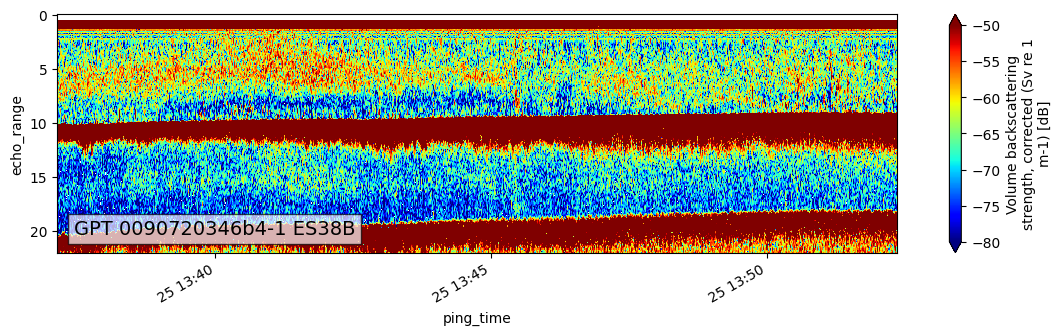

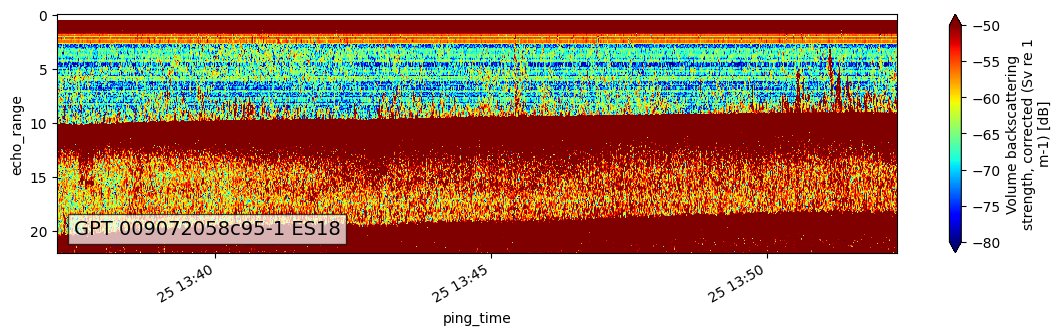

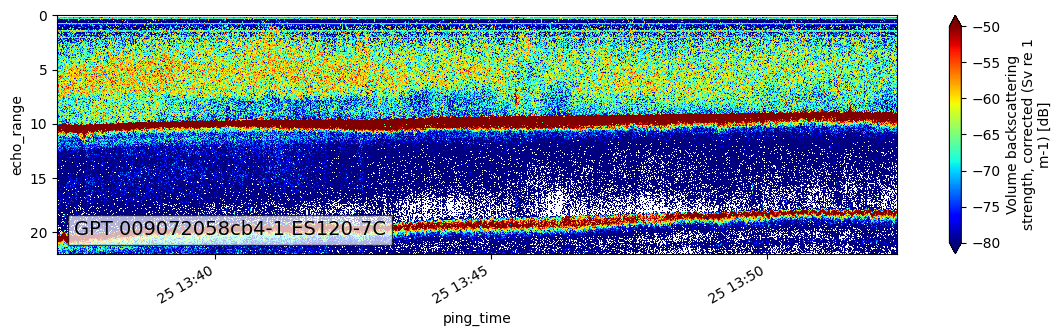

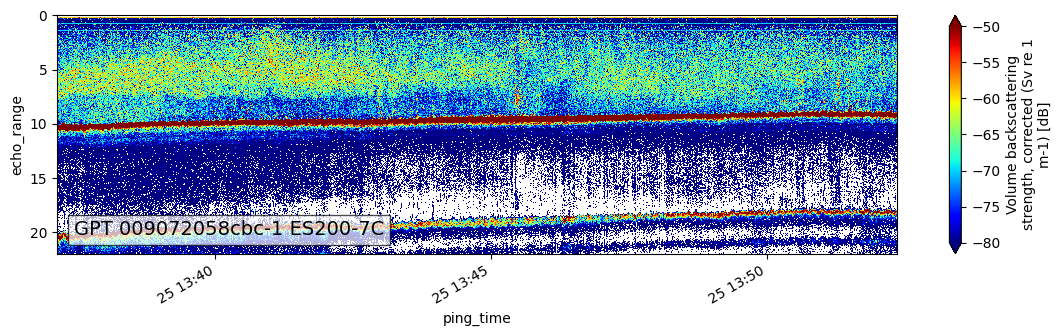

In [30]:
%%time

process_parameters = {
        "remove_background_noise": {
        "ping_num": 40,
        "range_sample_num": 10,
        "noise_max": -125,
        "SNR_threshold": 3,
    },

}
interpolated_ds = applying_masks_handler.apply_selected_noise_masks_and_or_noise_removal(
    interpolated_ds, 
    process_parameters
)

epviz.create_echogram(interpolated_ds,vmin=-80,vmax=-50)

### Apply `seabed` and  `false_seabed` masks

CPU times: user 24.1 s, sys: 7 s, total: 31.1 s
Wall time: 16.7 s


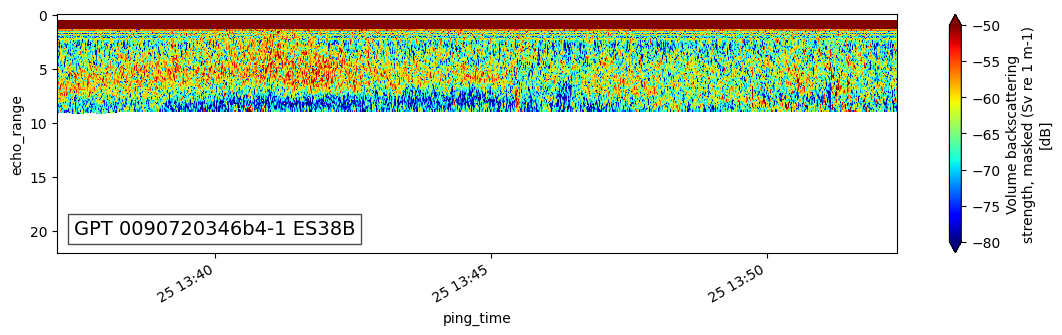

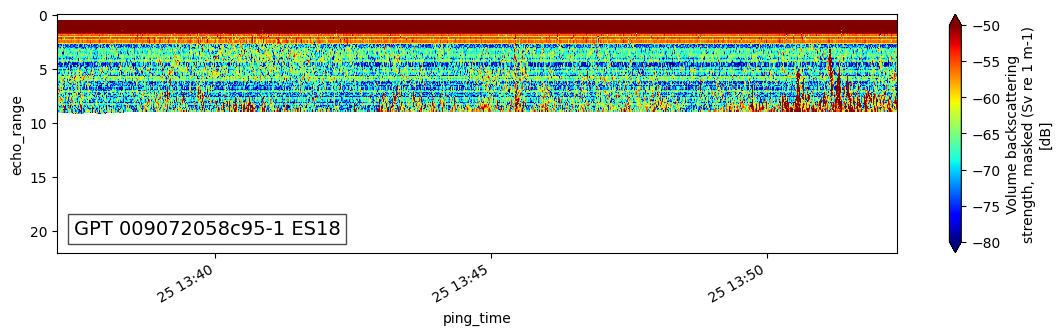

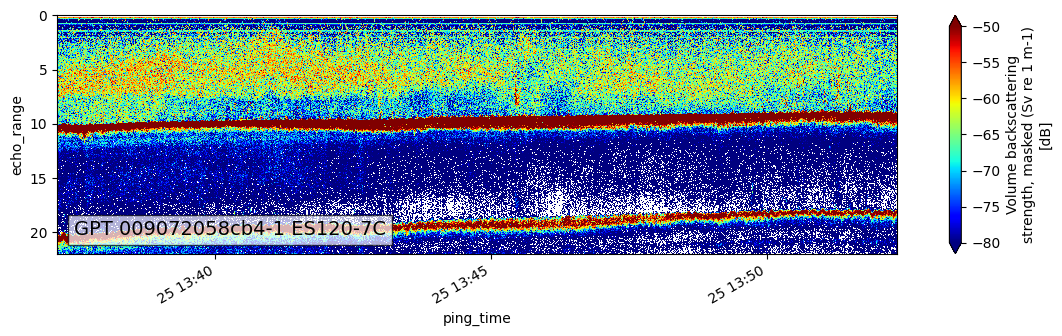

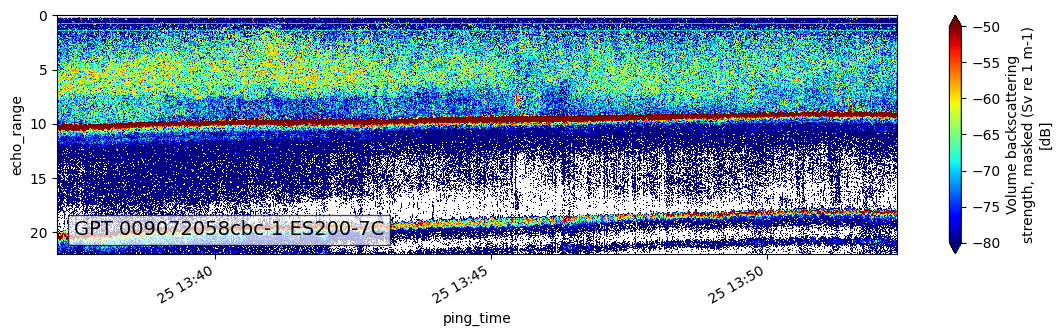

In [31]:
%%time

process_parameters = {
    'mask_seabed': {
    'var_name': 'Sv',
    },
    'mask_false_seabed': {
    'var_name': 'Sv',
    }
}

interpolated_ds = applying_masks_handler.apply_selected_noise_masks_and_or_noise_removal(
    interpolated_ds, 
    process_parameters
)

epviz.create_echogram(interpolated_ds,vmin=-80,vmax=-50)

# Compute general NASC

In [32]:
%%time

nasc = nasc_computation.compute_per_dataset_nasc(interpolated_ds, )
nasc['NASC_dataset']['NASC']

CPU times: user 10.4 s, sys: 2.86 s, total: 13.3 s
Wall time: 6.39 s


<xarray.DataArray 'NASC' (channel: 4, distance: 1, depth: 1)>
dask.array<mul, shape=(4, 1, 1), dtype=float64, chunksize=(4, 1, 1), chunktype=numpy.ndarray>
Coordinates:
  * distance  (distance) float64 0.0
  * channel   (channel) <U27 'GPT 0090720346b4-1 ES38B' ... 'GPT 009072058cbc...
  * depth     (depth) float64 0.0
Attributes:
    long_name:     Nautical Areal Scattering Coefficient (NASC, m2 nmi-2)
    units:         m2 nmi-2
    actual_range:  [12642.35, 1312757.488]

### Compute MVBS

In [33]:
%%time

interpolated_ds_MVBS = compute_mvbs(
    interpolated_ds, 
    method="physical_units", 
    range_bin="20m", 
    ping_time_bin="20S")
interpolated_ds_MVBS

CPU times: user 17 s, sys: 5.02 s, total: 22 s
Wall time: 7.37 s


<xarray.Dataset>
Dimensions:            (channel: 4, ping_time: 47, echo_range: 2)
Coordinates:
  * ping_time          (ping_time) datetime64[ns] 2019-09-25T13:37:00 ... 201...
  * channel            (channel) <U27 'GPT 0090720346b4-1 ES38B' ... 'GPT 009...
  * echo_range         (echo_range) float64 0.0 20.0
Data variables:
    Sv                 (channel, ping_time, echo_range) float64 dask.array<chunksize=(4, 47, 2), meta=np.ndarray>
    latitude           (ping_time) float64 30.15 30.15 30.15 ... 30.18 30.18
    longitude          (ping_time) float64 -88.57 -88.57 ... -88.54 -88.54
    water_level        float64 ...
    frequency_nominal  (channel) float64 ...
Attributes:
    processing_software_name:     echopype
    processing_software_version:  0.1.dev2333+gc260127
    processing_time:              2023-11-10T07:30:51Z
    processing_function:          commongrid.compute_MVBS
    processing_level:             Level 3B
    processing_level_url:         https://echopype.readthedocs.io/en/stable/p...

### Use frequency differencing handler

In [34]:
%%time

chan120 = 'GPT 009072058cb4-1 ES120-7C'
chan38 = 'GPT 0090720346b4-1 ES38B'
ds_Sv_with_krill_mask = frequency_differencing_handler.identify_krill(interpolated_ds, chan120=chan120, chan38=chan38)


chan120 = 'GPT 009072058cb4-1 ES120-7C'
chan38 = 'GPT 0090720346b4-1 ES38B'
ds_Sv_with_gas_bearing_organisms_mask = frequency_differencing_handler.identify_gas_bearing_organisms(
    ds_Sv_with_krill_mask,
    chan120=chan120,
    chan38=chan38
)


chan120 = 'GPT 009072058cb4-1 ES120-7C'
chan38 = 'GPT 0090720346b4-1 ES38B'
ds_Sv_with_fluid_like_organisms_mask = frequency_differencing_handler.identify_fluid_like_organisms(
    ds_Sv_with_gas_bearing_organisms_mask,
    chan120=chan120,
    chan38=chan38
)




ds_Sv_with_fluid_like_organisms_mask
# ds_Sv_with_shoal_combined_mask = shoal_detection_handler.attach_shoal_mask_to_ds(ds_Sv_with_fluid_like_organisms_mask)
# ds_Sv_with_shoal_combined_mask


CPU times: user 51 ms, sys: 9.57 ms, total: 60.5 ms
Wall time: 63.5 ms


<xarray.Dataset>
Dimensions:                        (channel: 4, ping_time: 4234,
                                    range_sample: 910, filenames: 1)
Coordinates:
  * channel                        (channel) <U27 'GPT 0090720346b4-1 ES38B' ...
  * ping_time                      (ping_time) datetime64[ns] 2019-09-25T13:3...
  * range_sample                   (range_sample) int64 0 1 2 3 ... 907 908 909
  * filenames                      (filenames) int64 0
Data variables: (12/38)
    Sv_denoised                    (channel, ping_time, range_sample) float64 ...
    echo_range                     (channel, ping_time, range_sample) float64 ...
    frequency_nominal              (channel) float64 ...
    sound_speed                    float64 1.51e+03
    sound_absorption               (channel) float64 0.009878 ... 0.05316
    temperature                    float64 10.0
    ...                             ...
    Sv_with_background_noise       (channel, ping_time, range_sample) float64 dask.array<chunksize=(1, 4234, 910), meta=np.ndarray>
    Sv_noise                       (channel, ping_time, range_sample) float64 dask.array<chunksize=(1, 4200, 910), meta=np.ndarray>
    Sv                             (channel, ping_time, range_sample) float64 dask.array<chunksize=(1, 4200, 910), meta=np.ndarray>
    mask_krill                     (ping_time, range_sample) bool dask.array<chunksize=(4200, 910), meta=np.ndarray>
    mask_gas_bearing_organisms     (ping_time, range_sample) bool dask.array<chunksize=(4200, 910), meta=np.ndarray>
    mask_fluid_like_organisms      (ping_time, range_sample) bool dask.array<chunksize=(4200, 910), meta=np.ndarray>
Attributes:
    processing_software_name:     echopype
    processing_software_version:  0.1.dev2333+gc260127
    processing_time:              2023-11-10T07:29:54Z
    processing_function:          clean.remove_noise
    processing_level:             Level 3B
    processing_level_url:         https://echopype.readthedocs.io/en/stable/p...
    mask_software_name:           echopype
    mask_software_version:        0.1.dev2333+gc260127
    mask_time:                    2023-11-10T07:30:18Z
    mask_function:                mask.apply_mask

**The shoal detection process is notably time-consuming. That's why we do not compute the shoal_mask here for now until we have an efficient method.**

In [44]:
ds_Sv_with_shoal_combined_mask = ds_Sv_with_fluid_like_organisms_mask 

### Apply `krill` mask

CPU times: user 24 s, sys: 6.35 s, total: 30.4 s
Wall time: 17.6 s


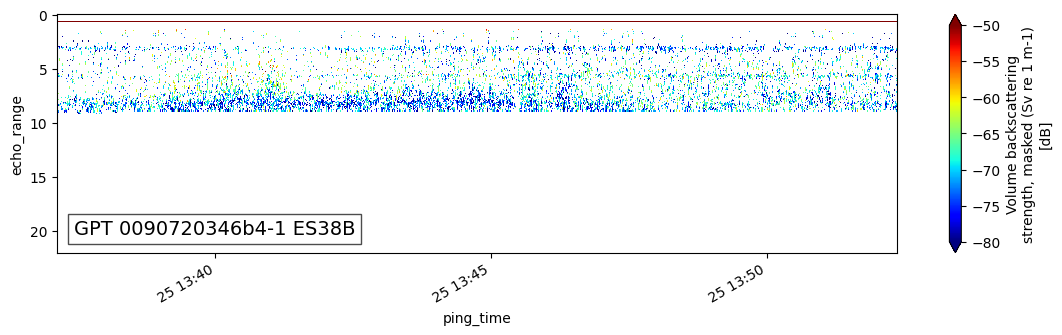

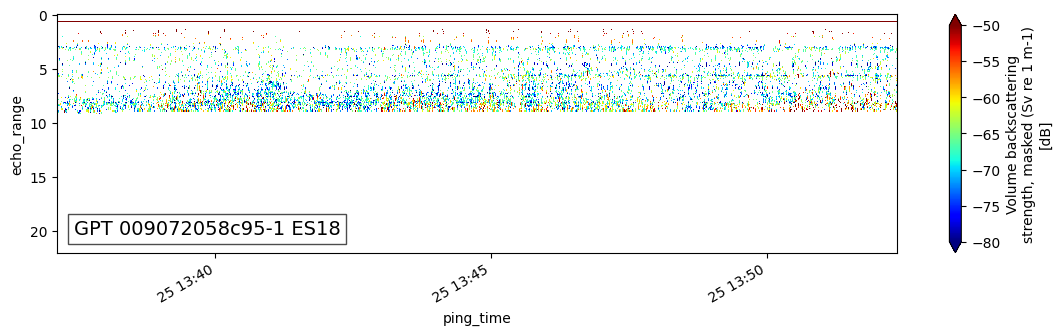

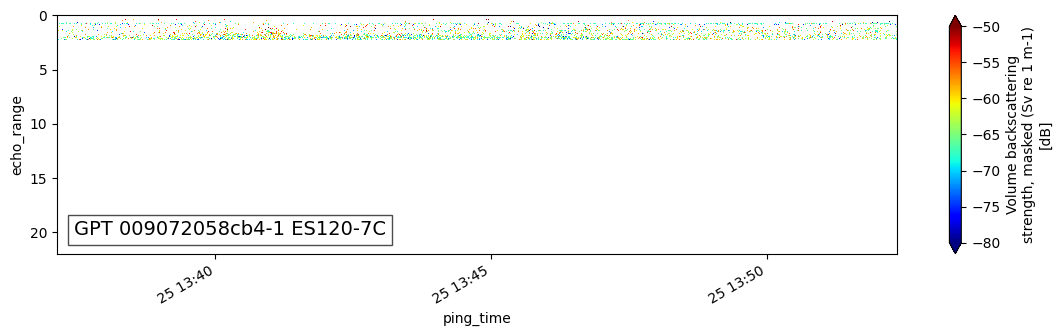

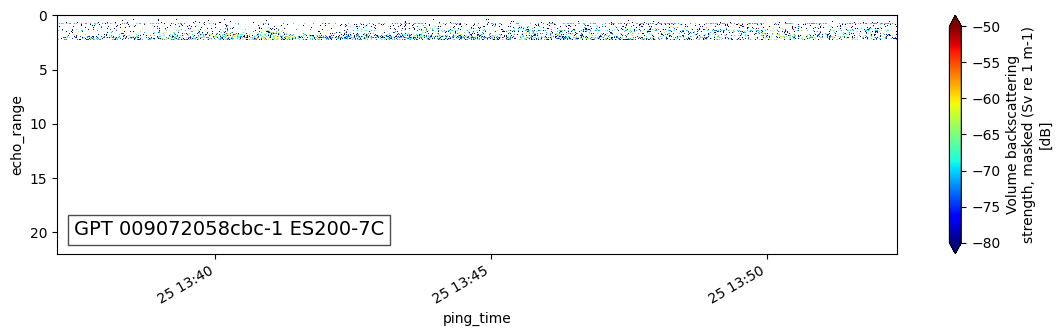

In [36]:
%%time

process_parameters = {
    'mask_krill': {
        'var_name': 'Sv',
    },
#     'mask_shoal': {
#         'var_name': 'Sv',
#     }
}

organisms_ds = apply_mask_organisms_in_order(ds_Sv_with_shoal_combined_mask, process_parameters)
epviz.create_echogram(organisms_ds,vmin=-80,vmax=-50)

### Compute krill NASC

In [37]:
%%time

krill_nasc = nasc_computation.compute_per_dataset_nasc(organisms_ds)
krill_nasc['NASC_dataset']['NASC']

CPU times: user 11.9 s, sys: 3.96 s, total: 15.9 s
Wall time: 8 s


<xarray.DataArray 'NASC' (channel: 4, distance: 1, depth: 1)>
dask.array<mul, shape=(4, 1, 1), dtype=float64, chunksize=(4, 1, 1), chunktype=numpy.ndarray>
Coordinates:
  * distance  (distance) float64 0.0
  * channel   (channel) <U27 'GPT 0090720346b4-1 ES38B' ... 'GPT 009072058cbc...
  * depth     (depth) float64 0.0
Attributes:
    long_name:     Nautical Areal Scattering Coefficient (NASC, m2 nmi-2)
    units:         m2 nmi-2
    actual_range:  [474.481, 20856.425]

### Save the processed dataset

In [38]:
%%time

os.makedirs(os.path.join(oceanstream_ek80_path, 'test'), exist_ok=True)
processed_data_io.write_processed(
    sv = organisms_ds,
    file_path = os.path.join(oceanstream_ek80_path, 'test'),
    file_name = "test_processed_EK80_T133707",
    file_type = "nc",
)

organisms_ds

CPU times: user 3.53 s, sys: 1.75 s, total: 5.28 s
Wall time: 2.71 s


<xarray.Dataset>
Dimensions:                        (channel: 4, ping_time: 4234,
                                    range_sample: 910, filenames: 1)
Coordinates:
  * channel                        (channel) <U27 'GPT 0090720346b4-1 ES38B' ...
  * ping_time                      (ping_time) datetime64[ns] 2019-09-25T13:3...
  * range_sample                   (range_sample) int64 0 1 2 3 ... 907 908 909
  * filenames                      (filenames) int64 0
Data variables: (12/38)
    Sv_denoised                    (channel, ping_time, range_sample) float64 ...
    echo_range                     (channel, ping_time, range_sample) float64 ...
    frequency_nominal              (channel) float64 ...
    sound_speed                    float64 1.51e+03
    sound_absorption               (channel) float64 0.009878 ... 0.05316
    temperature                    float64 10.0
    ...                             ...
    Sv_with_background_noise       (channel, ping_time, range_sample) float64 dask.array<chunksize=(1, 4234, 910), meta=np.ndarray>
    Sv_noise                       (channel, ping_time, range_sample) float64 dask.array<chunksize=(1, 4200, 910), meta=np.ndarray>
    Sv                             (channel, ping_time, range_sample) float64 dask.array<chunksize=(1, 4200, 910), meta=np.ndarray>
    mask_krill                     (ping_time, range_sample) bool dask.array<chunksize=(4200, 910), meta=np.ndarray>
    mask_gas_bearing_organisms     (ping_time, range_sample) bool dask.array<chunksize=(4200, 910), meta=np.ndarray>
    mask_fluid_like_organisms      (ping_time, range_sample) bool dask.array<chunksize=(4200, 910), meta=np.ndarray>
Attributes:
    processing_software_name:     echopype
    processing_software_version:  0.1.dev2333+gc260127
    processing_time:              2023-11-10T07:29:54Z
    processing_function:          clean.remove_noise
    processing_level:             Level 3B
    processing_level_url:         https://echopype.readthedocs.io/en/stable/p...
    mask_software_name:           echopype
    mask_software_version:        0.1.dev2333+gc260127
    mask_time:                    2023-11-10T07:30:58Z
    mask_function:                mask.apply_mask

### Read the saved dataset

In [39]:
%%time

test_ds = processed_data_io.read_processed(
    file_path=os.path.join(
        oceanstream_ek80_path, 
        'test',
        'test_processed_EK80_T133707.nc'
    )
)
test_ds

CPU times: user 68.7 ms, sys: 680 ms, total: 748 ms
Wall time: 862 ms


<xarray.Dataset>
Dimensions:                        (channel: 4, ping_time: 4234,
                                    range_sample: 910, filenames: 1)
Coordinates:
  * channel                        (channel) object 'GPT 0090720346b4-1 ES38B...
  * ping_time                      (ping_time) datetime64[ns] 2019-09-25T13:3...
  * range_sample                   (range_sample) int64 0 1 2 3 ... 907 908 909
  * filenames                      (filenames) int64 0
Data variables: (12/38)
    Sv_denoised                    (channel, ping_time, range_sample) float64 ...
    echo_range                     (channel, ping_time, range_sample) float64 ...
    frequency_nominal              (channel) float64 3.8e+04 1.8e+04 ... 2e+05
    sound_speed                    float64 1.51e+03
    sound_absorption               (channel) float64 0.009878 ... 0.05316
    temperature                    float64 10.0
    ...                             ...
    Sv_with_background_noise       (channel, ping_time, range_sample) float64 ...
    Sv_noise                       (channel, ping_time, range_sample) float64 ...
    Sv                             (channel, ping_time, range_sample) float64 ...
    mask_krill                     (ping_time, range_sample) bool False ... F...
    mask_gas_bearing_organisms     (ping_time, range_sample) bool False ... F...
    mask_fluid_like_organisms      (ping_time, range_sample) bool False ... F...
Attributes:
    processing_software_name:     echopype
    processing_software_version:  0.1.dev2333+gc260127
    processing_time:              2023-11-10T07:29:54Z
    processing_function:          clean.remove_noise
    processing_level:             Level 3B
    processing_level_url:         https://echopype.readthedocs.io/en/stable/p...
    mask_software_name:           echopype
    mask_software_version:        0.1.dev2333+gc260127
    mask_time:                    2023-11-10T07:30:58Z
    mask_function:                mask.apply_mask

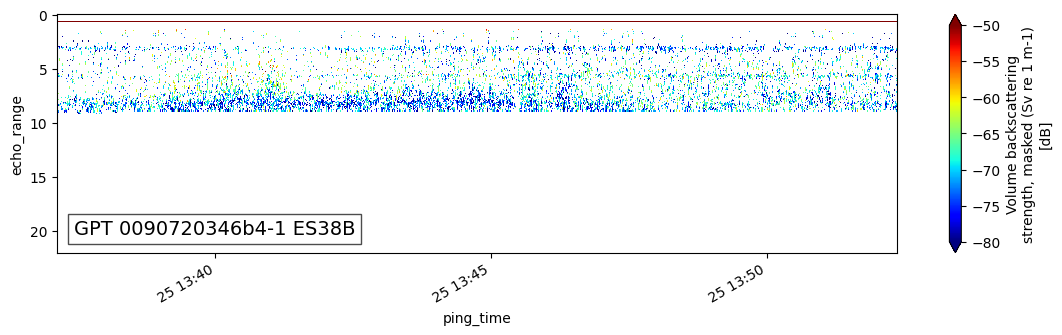

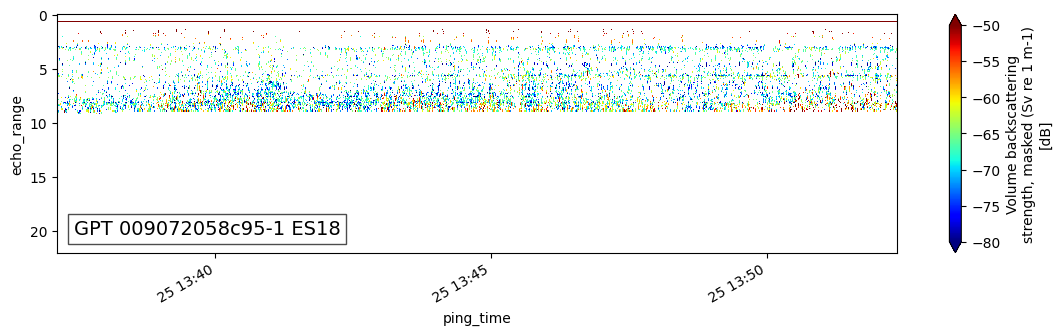

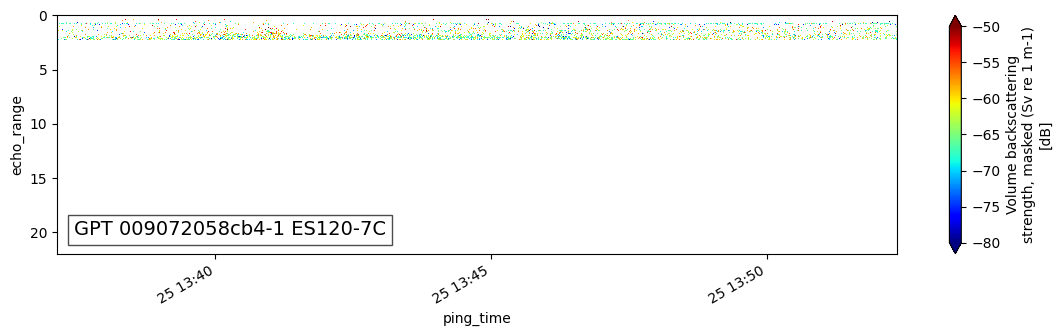

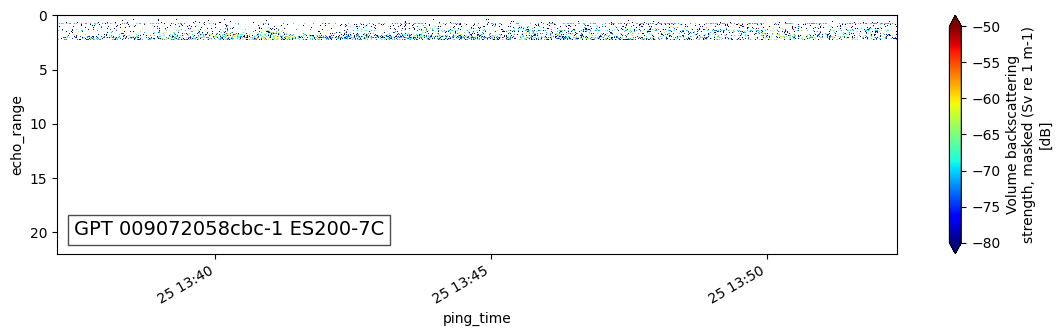

In [40]:
epviz.create_echogram(test_ds,vmin=-80,vmax=-50)

### NASC on chunked data

In [41]:
organisms_ds

<xarray.Dataset>
Dimensions:                        (channel: 4, ping_time: 4234,
                                    range_sample: 910, filenames: 1)
Coordinates:
  * channel                        (channel) <U27 'GPT 0090720346b4-1 ES38B' ...
  * ping_time                      (ping_time) datetime64[ns] 2019-09-25T13:3...
  * range_sample                   (range_sample) int64 0 1 2 3 ... 907 908 909
  * filenames                      (filenames) int64 0
Data variables: (12/38)
    Sv_denoised                    (channel, ping_time, range_sample) float64 ...
    echo_range                     (channel, ping_time, range_sample) float64 ...
    frequency_nominal              (channel) float64 ...
    sound_speed                    float64 1.51e+03
    sound_absorption               (channel) float64 0.009878 ... 0.05316
    temperature                    float64 10.0
    ...                             ...
    Sv_with_background_noise       (channel, ping_time, range_sample) float64 dask.array<chunksize=(1, 4234, 910), meta=np.ndarray>
    Sv_noise                       (channel, ping_time, range_sample) float64 dask.array<chunksize=(1, 4200, 910), meta=np.ndarray>
    Sv                             (channel, ping_time, range_sample) float64 dask.array<chunksize=(1, 4200, 910), meta=np.ndarray>
    mask_krill                     (ping_time, range_sample) bool dask.array<chunksize=(4200, 910), meta=np.ndarray>
    mask_gas_bearing_organisms     (ping_time, range_sample) bool dask.array<chunksize=(4200, 910), meta=np.ndarray>
    mask_fluid_like_organisms      (ping_time, range_sample) bool dask.array<chunksize=(4200, 910), meta=np.ndarray>
Attributes:
    processing_software_name:     echopype
    processing_software_version:  0.1.dev2333+gc260127
    processing_time:              2023-11-10T07:29:54Z
    processing_function:          clean.remove_noise
    processing_level:             Level 3B
    processing_level_url:         https://echopype.readthedocs.io/en/stable/p...
    mask_software_name:           echopype
    mask_software_version:        0.1.dev2333+gc260127
    mask_time:                    2023-11-10T07:30:58Z
    mask_function:                mask.apply_mask

In [42]:
organisms_ds.chunk()

<xarray.Dataset>
Dimensions:                        (channel: 4, ping_time: 4234,
                                    range_sample: 910, filenames: 1)
Coordinates:
  * channel                        (channel) <U27 'GPT 0090720346b4-1 ES38B' ...
  * ping_time                      (ping_time) datetime64[ns] 2019-09-25T13:3...
  * range_sample                   (range_sample) int64 0 1 2 3 ... 907 908 909
  * filenames                      (filenames) int64 0
Data variables: (12/38)
    Sv_denoised                    (channel, ping_time, range_sample) float64 dask.array<chunksize=(4, 4234, 910), meta=np.ndarray>
    echo_range                     (channel, ping_time, range_sample) float64 dask.array<chunksize=(4, 4234, 910), meta=np.ndarray>
    frequency_nominal              (channel) float64 dask.array<chunksize=(4,), meta=np.ndarray>
    sound_speed                    float64 1.51e+03
    sound_absorption               (channel) float64 dask.array<chunksize=(4,), meta=np.ndarray>
    temperature                    float64 10.0
    ...                             ...
    Sv_with_background_noise       (channel, ping_time, range_sample) float64 dask.array<chunksize=(1, 4234, 910), meta=np.ndarray>
    Sv_noise                       (channel, ping_time, range_sample) float64 dask.array<chunksize=(1, 4200, 910), meta=np.ndarray>
    Sv                             (channel, ping_time, range_sample) float64 dask.array<chunksize=(1, 4200, 910), meta=np.ndarray>
    mask_krill                     (ping_time, range_sample) bool dask.array<chunksize=(4200, 910), meta=np.ndarray>
    mask_gas_bearing_organisms     (ping_time, range_sample) bool dask.array<chunksize=(4200, 910), meta=np.ndarray>
    mask_fluid_like_organisms      (ping_time, range_sample) bool dask.array<chunksize=(4200, 910), meta=np.ndarray>
Attributes:
    processing_software_name:     echopype
    processing_software_version:  0.1.dev2333+gc260127
    processing_time:              2023-11-10T07:29:54Z
    processing_function:          clean.remove_noise
    processing_level:             Level 3B
    processing_level_url:         https://echopype.readthedocs.io/en/stable/p...
    mask_software_name:           echopype
    mask_software_version:        0.1.dev2333+gc260127
    mask_time:                    2023-11-10T07:30:58Z
    mask_function:                mask.apply_mask

In [43]:
%%time

krill_nasc = nasc_computation.compute_per_dataset_nasc(organisms_ds.chunk())
krill_nasc['NASC_dataset']['NASC']

CPU times: user 14.1 s, sys: 4.74 s, total: 18.9 s
Wall time: 6.84 s


<xarray.DataArray 'NASC' (channel: 4, distance: 1, depth: 1)>
dask.array<mul, shape=(4, 1, 1), dtype=float64, chunksize=(4, 1, 1), chunktype=numpy.ndarray>
Coordinates:
  * distance  (distance) float64 0.0
  * channel   (channel) <U27 'GPT 0090720346b4-1 ES38B' ... 'GPT 009072058cbc...
  * depth     (depth) float64 0.0
Attributes:
    long_name:     Nautical Areal Scattering Coefficient (NASC, m2 nmi-2)
    units:         m2 nmi-2
    actual_range:  [474.481, 20856.425]